In [8]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from typing import Tuple
import os
from skimage.io import imread
from tqdm.notebook import tqdm
import random
from metric_tree import *
from search_alg_visited_nodes import defeatist_search_vn, search_pruning_vn
from search_algorithms import exact_nn_search

In [149]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.spatial.distance import cdist
from typing import Tuple

colors = [name for name, color in mcolors.TABLEAU_COLORS.items()]

# Metric tree avec le choix du pivot donné dans le papier
class MetricTreebis:
    def __init__(self, points: np.ndarray = None, First: bool = True) -> None:
        self.root = None
        self.mu = None
        self.left = None
        self.min_left = None
        self.max_left = None
        self.right = None
        self.min_right = None
        self.max_right = None
        self.size = None
        self.p = 0.2
        self.First = First
        if points is not None:
            self.build(points)

    def median_mu(
        self, points: np.ndarray, pivot: np.ndarray, distances, subset_size: int
    ) -> float:
        subset_idx = np.random.choice(len(points) - 1, size=subset_size, replace=False)
        # subset_points = points[subset_idx]
        distances_to_pivot = distances[subset_idx]
        return np.median(distances_to_pivot)

    def left_right_split(
        self, mu: float, points: np.ndarray, distances: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray, float, float, float, float]:
        """
        Splits the points into left and right depending on their distance to root node.
        Points and distances are ordered by ascending distance to root node.

        Parameters
        ----------
        mu : float
            Threshold value for splitting the points
        points : np.ndarray
            Array of points to be splitted
        distances : np.ndarray
            Distances of the points to the root node

        Returns
        -------
        Tuple[np.ndarray, np.ndarray, float, float, float, float]
            Corresponds to the left and right subtree points with
            their min and max distances to the root node
        """
        if len(points) == 1:
            dist_to_pivot = distances[0]
            return points, None, dist_to_pivot, dist_to_pivot, None, None
        idx = np.searchsorted(distances, mu, side="right")
        points_left = points[:idx]
        points_right = points[idx:]
        return (
            points_left,
            points_right,
            distances[0],
            distances[idx - 1],
            distances[idx],
            distances[-1],
        )

    def pivot_choice(self, points, p) -> int:
        ## For the moment only random choice
        if self.First:
            standard_dev = []
            indices = [i for i in range(len(points))]
            k = int(p*len(points)) + 1
            choices_idx = random.choices(indices, k=k)
            for pivot_id in choices_idx:
                remaining = np.delete(points, pivot_id, 0)
                sample_points = random.choices(remaining, k=k)
                dist = cdist(points[pivot_id].reshape(1,*points[pivot_id].shape), sample_points)[0]
                standard_dev.append(np.std(dist))
            return np.argmax(np.array(standard_dev))
        else:
            return len(points)-1

    def __repr__(self) -> str:
        return f"MetricTree: root={self.root}, size={self.size}"

    def __len__(self) -> int:
        return self.size

    def build(self, points: np.ndarray, subset_size: int = 10000):
        self.size = len(points)
        if len(points) == 0:
            return None
        if len(points) == 1:
            self.root = points[0]
            return self
        ## Selection of the pivot
        pivot_idx = self.pivot_choice(points, self.p)
        remaining_points = np.delete(points, pivot_idx, 0)
        self.root = points[pivot_idx]

        ## Compute distances
        distances = cdist(self.root.reshape(1, *self.root.shape), remaining_points)[0]

        ## Sort the points by distance to the root
        sorted_indices = np.argsort(distances)
        distances = distances[sorted_indices]
        remaining_points = remaining_points[sorted_indices]
        # print(remaining_points)
        # print(distances)

        ## Compute median on a subset of remaining points
        mu = self.median_mu(
            remaining_points,
            self.root,
            distances,
            min(len(remaining_points) - 1, subset_size),
        )
        self.mu = mu

        ## Split the points into left and right trees
        (
            points_left,
            points_right,
            self.min_left,
            self.max_left,
            self.min_right,
            self.max_right,
        ) = self.left_right_split(mu, remaining_points, distances)


        ## Build the left and right trees if needed
        if points_left is not None:
            self.left = MetricTreebis(First=False).build(points_left)
        if points_right is not None:
            self.right = MetricTreebis(First=False).build(points_right)
        return self

    def plot(self, color=None, fig=None, ax=None):
        if color is None:
            color = np.random.choice(colors)
        if fig is None:
            fig, ax = plt.subplots()

        ax.scatter(self.root[0], self.root[1], color=color)
        if self.left is not None:
            ax.plot(
                [self.root[0], self.left.root[0]],
                [self.root[1], self.left.root[1]],
                color=color,
            )
            self.left.plot(color, fig, ax)
        if self.right is not None:
            ax.plot(
                [self.root[0], self.right.root[0]],
                [self.root[1], self.right.root[1]],
                color=color,
            )
            self.right.plot(color, fig, ax)


In [158]:
points = np.random.rand(10000, 2)

In [159]:
tree = MetricTree(points)
tree_bis = MetricTreebis(points)

[]

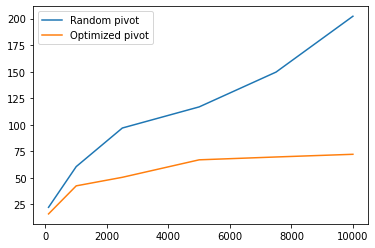

In [167]:
mean_vns = []
mean_vns_bis = []
for i in tqdm([100, 1000, 2500, 5000, 7500, 10000]):
    points = np.random.rand(i, 2)
    tree = MetricTree(points)
    tree_bis = MetricTreebis(points)
    correct = 0
    correct_bis = 0
    n_try = 1000
    vns = []
    vns_bis = []
    for i in range(n_try):
        q = np.random.rand(2)
        true_nn = exact_nn_search(points, q)[0]
        result, vn = search_pruning_vn(tree, q)[0], search_pruning_vn(tree, q)[2]
        result_bis, vn_bis = search_pruning_vn(tree_bis, q)[0], search_pruning_vn(tree_bis, q)[2]
        vns.append(vn)
        vns_bis.append(vn_bis)
    mean_vns.append(np.mean(vns))
    mean_vns_bis.append(np.mean(vns_bis))

plt.plot([100, 1000, 2500, 5000, 7500, 10000], mean_vns, label='Random pivot')
plt.plot([100, 1000, 2500, 5000, 7500, 10000], mean_vns_bis, label='Optimized pivot')
plt.legend()
plt.plot()